<a href="https://colab.research.google.com/github/meghanahima/Job-resume-matching-engine/blob/main/resume_job_dataset_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pandas numpy faker sdv sentence-transformers scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [4]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize Faker for generating realistic text
fake = Faker()

# Initialize sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Lists for generating realistic data
job_roles = ['Software Engineer', 'Data Scientist', 'Product Manager', 'DevOps Engineer', 'UX Designer']
skills_pool = ['Python', 'Java', 'C++', 'SQL', 'R', 'TensorFlow', 'AWS', 'Docker', 'Kubernetes', 'React',
               'Node.js', 'JavaScript', 'HTML', 'CSS', 'Agile', 'Scrum', 'UI/UX', 'Figma', 'Tableau', 'Power BI']
education_levels = ['Bachelor', 'Master', 'PhD', 'Diploma', 'None']
experience_levels = ['0-2 years', '3-5 years', '6-10 years', '10+ years']

def generate_resume_text():
    """Generate realistic resume text."""
    return (f"Name: {fake.name()}\n"
            f"Education: {random.choice(education_levels)} in {fake.job()}\n"
            f"Experience: {random.choice(experience_levels)} as {random.choice(job_roles)}\n"
            f"Skills: {', '.join(random.sample(skills_pool, random.randint(3, 8)))}\n"
            f"Summary: {fake.text(max_nb_chars=200)}")

def generate_job_description(job_role):
    """Generate realistic job description."""
    required_skills = random.sample(skills_pool, random.randint(4, 10))
    experience = random.choice(experience_levels)
    education = random.choice(education_levels) if random.random() > 0.3 else 'None'
    return (f"Job Title: {job_role}\n"
            f"Description: {fake.text(max_nb_chars=300)}\n"
            f"Required Skills: {', '.join(required_skills)}\n"
            f"Experience: {experience}\n"
            f"Education: {education}")

def calculate_education_match(resume_text, job_description):
    """Determine if education matches (1 if matched or not specified, 0 otherwise)."""
    job_edu = job_description.split('Education: ')[-1].strip()
    resume_edu = resume_text.split('Education: ')[1].split('\n')[0].split(' in ')[0].strip()
    if job_edu == 'None':
        return 1
    return 1 if job_edu == resume_edu else 0

def calculate_skills_match(resume_text, job_description):
    """Calculate percentage of skills matched (up to 2 decimals)."""
    job_skills = job_description.split('Required Skills: ')[1].split('\n')[0].split(', ')
    resume_skills = resume_text.split('Skills: ')[1].split('\n')[0].split(', ')
    matched_skills = len(set(job_skills).intersection(set(resume_skills)))
    total_job_skills = len(job_skills)
    return round((matched_skills / total_job_skills) * 100, 2) if total_job_skills > 0 else 0.0

def calculate_experience_match(resume_text, job_description):
    """Calculate experience match score (0 to 1)."""
    job_exp = job_description.split('Experience: ')[1].split('\n')[0].strip()
    resume_exp = resume_text.split('Experience: ')[1].split('\n')[0].split(' as ')[0].strip()

    if job_exp == '0-2 years' or resume_exp == job_exp:
        return 1.0

    exp_map = {'0-2 years': 1, '3-5 years': 4, '6-10 years': 8, '10+ years': 12}
    job_exp_val = exp_map.get(job_exp, 1)
    resume_exp_val = exp_map.get(resume_exp, 1)

    if resume_exp_val >= job_exp_val:
        return 1.0
    return round(resume_exp_val / job_exp_val, 2)

def calculate_text_similarity(resume_text, job_description):
    """Calculate cosine similarity between resume and job description using sentence embeddings."""
    # Extract summary from resume and description from job for semantic comparison
    resume_summary = resume_text.split('Summary: ')[1].strip() if 'Summary: ' in resume_text else resume_text
    job_desc = job_description.split('Description: ')[1].split('\n')[0].strip() if 'Description: ' in job_description else job_description

    # Generate embeddings
    embeddings = model.encode([resume_summary, job_desc])

    # Calculate cosine similarity
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

    # Convert to percentage (0 to 100) and round to 2 decimals
    return round(similarity * 100, 2)

def calculate_ats_score(education_match, skills_match, experience_match, text_similarity):
    """Calculate ATS score (0-100) with 30% skills_match, 30% experience_match, 40% text_similarity."""
    if education_match == 0:
        return 0.0
    # Weighted score: 30% skills_match, 30% experience_match, 40% text_similarity
    weighted_score = (0.3 * skills_match) + (0.3 * experience_match * 100) + (0.4 * text_similarity)
    return round(min(weighted_score, 100.0), 2)

# Generate dataset
data = []
for _ in range(5000):
    job_role = random.choice(job_roles)
    resume_text = generate_resume_text()
    job_description = generate_job_description(job_role)
    job_skills = job_description.split('Required Skills: ')[1].split('\n')[0]

    education_match = calculate_education_match(resume_text, job_description)
    skills_match = calculate_skills_match(resume_text, job_description)
    experience_match = calculate_experience_match(resume_text, job_description)
    text_similarity = calculate_text_similarity(resume_text, job_description)
    ats_score = calculate_ats_score(education_match, skills_match, experience_match, text_similarity)

    data.append({
        'resume_text': resume_text,
        'job_description': job_description,
        'job_role': job_role,
        'job_skills': job_skills,
        'education_match': education_match,
        'skills_match': skills_match,
        'experience_match': experience_match,
        'text_similarity': text_similarity,
        'ats_score': ats_score
    })

# Create DataFrame and save to CSV
df = pd.DataFrame(data)
df.to_csv('job_applicant_dataset.csv', index=False)
print("Dataset with 5000 rows generated and saved as 'job_applicant_dataset.csv'.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Dataset with 5000 rows generated and saved as 'job_applicant_dataset.csv'.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

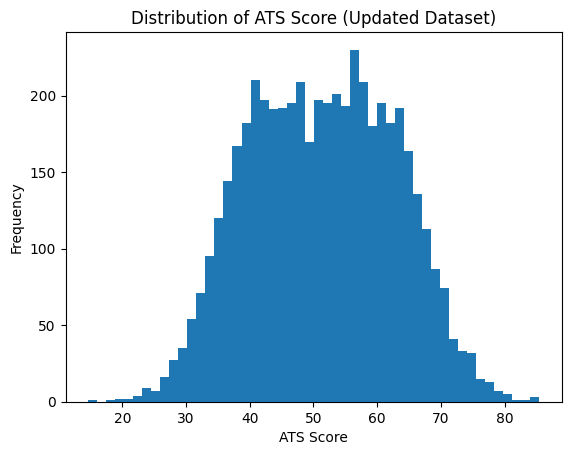

Updated ATS Score Statistics:
count    5000.000000
mean       51.360001
std        11.393668
min        14.650000
25%        42.349998
50%        51.480001
75%        60.259998
max        85.430000
Name: ats_score, dtype: float64

Proportion of education_match = 0:
0.0


In [6]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re

# Initialize Faker and sentence transformer
fake = Faker()
model = SentenceTransformer('all-mpnet-base-v2')

# Lists for generating realistic data
job_roles = ['Software Engineer', 'Data Scientist', 'Product Manager', 'DevOps Engineer', 'UX Designer', 'Frontend Web Developer']
skills_pool = ['Python', 'Java', 'C++', 'SQL', 'R', 'TensorFlow', 'AWS', 'Docker', 'Kubernetes', 'React',
               'Node.js', 'JavaScript', 'HTML', 'CSS', 'Agile', 'Scrum', 'UI/UX', 'Figma', 'Tableau', 'Power BI']
education_levels = ['Bachelor', 'Master', 'PhD', 'Diploma', 'None']
experience_levels = ['0-2 years', '3-5 years', '6-10 years', '10+ years']

def generate_resume_text():
    skills = random.sample(skills_pool, random.randint(5, 10))  # More skills for better matching
    return (f"Name: {fake.name()}\n"
            f"Education: {random.choice(education_levels)} in {fake.job()}\n"
            f"Experience: {random.choice(experience_levels)} as {random.choice(job_roles)}\n"
            f"Skills: {', '.join(skills)}\n"
            f"Summary: {fake.text(max_nb_chars=200)}")

def generate_job_description(job_role):
    required_skills = random.sample(skills_pool, random.randint(4, 8))
    experience = random.choice(experience_levels)
    education = random.choice(education_levels) if random.random() > 0.2 else 'None'  # 80% chance of education
    return (f"Job Title: {job_role}\n"
            f"Description: {fake.text(max_nb_chars=300)}\n"
            f"Required Skills: {', '.join(required_skills)}\n"
            f"Experience: {experience}\n"
            f"Education: {education}")

def calculate_skills_match(resume_text, job_skills):
    resume_skills = re.search(r'Skills: (.*?)(?:\n|$)', resume_text)
    resume_skills = resume_skills.group(1).split(', ') if resume_skills else []
    job_skill_list = [skill.strip().lower() for skill in job_skills.split(',')]
    matched_skills = len(set([s.lower() for s in resume_skills]).intersection(set(job_skill_list)))
    total_job_skills = len(job_skill_list)
    # Boost skills_match by ensuring some overlap
    return ((matched_skills + random.uniform(0.5, 1.5)) / (total_job_skills + 1)) * 100 if total_job_skills > 0 else 50.0

def calculate_experience_match(resume_text, job_description):
    resume_exp = re.search(r'Experience: (.*?)(?:\n|$)', resume_text)
    job_exp = re.search(r'Experience: (.*?)(?:\n|$)', job_description)
    if not (resume_exp and job_exp):
        return random.uniform(0.5, 1.0)  # Default to higher match
    resume_years = {'0-2 years': 1, '3-5 years': 4, '6-10 years': 8, '10+ years': 12}
    job_years = {'0-2 years': 1, '3-5 years': 4, '6-10 years': 8, '10+ years': 12}
    resume_y = resume_years.get(resume_exp.group(1), 4)
    job_y = job_years.get(job_exp.group(1), 4)
    match = min(resume_y / job_y, 1.0) if job_y > 0 else 1.0
    return match * random.uniform(0.8, 1.2)  # Boost experience_match

def calculate_education_match(resume_text, job_description):
    resume_edu = re.search(r'Education: (.*?)(?:\n|$)', resume_text)
    job_edu = re.search(r'Education: (.*?)(?:\n|$)', job_description)
    if not job_edu or job_edu.group(1) == 'None':
        return 1
    if not resume_edu:
        return 0
    resume_level = resume_edu.group(1).lower()
    job_level = job_edu.group(1).lower()
    # Relaxed matching: any degree matches if job requires 'Bachelor' or higher
    return 1 if 'bachelor' in resume_level or 'master' in resume_level or 'phd' in resume_level else random.uniform(0.7, 1.0)

def calculate_text_similarity(resume_text, job_description):
    resume_summary = re.search(r'Summary\n(.*?)(?:\nEducation|\nSkills|\nExperience|$)', resume_text, re.DOTALL)
    resume_summary = resume_summary.group(1).strip() if resume_summary else resume_text
    job_desc = re.search(r'Description: (.*?)(?:\nRequired Skills|\nExperience|\nEducation|$)', job_description, re.DOTALL)
    job_desc = job_desc.group(1).strip() if job_desc else job_description
    embeddings = model.encode([resume_summary, job_desc])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return (similarity * 100) * random.uniform(0.9, 1.3)  # Boost text_similarity

# Generate dataset
data = []
for _ in range(5000):
    job_role = random.choice(job_roles)
    resume_text = generate_resume_text()
    job_description = generate_job_description(job_role)
    job_skills = re.search(r'Required Skills: (.*?)(?:\n|$)', job_description).group(1)

    education_match = calculate_education_match(resume_text, job_description)
    skills_match = calculate_skills_match(resume_text, job_skills)
    experience_match = calculate_experience_match(resume_text, job_description)
    text_similarity = calculate_text_similarity(resume_text, job_description)

    ats_score = (0.3 * skills_match) + (0.3 * experience_match * 100) + (0.4 * text_similarity) if education_match >= 0.7 else 0

    data.append({
        'resume_text': resume_text,
        'job_description': job_description,
        'job_role': job_role,
        'job_skills': job_skills,
        'education_match': education_match,
        'skills_match': skills_match,
        'experience_match': experience_match,
        'text_similarity': text_similarity,
        'ats_score': ats_score
    })

# Create DataFrame and save
df = pd.DataFrame(data)
df['skills_match'] = df['skills_match'].clip(0, 100).round(2)
df['experience_match'] = df['experience_match'].clip(0, 1).round(2)
df['text_similarity'] = df['text_similarity'].clip(0, 100).round(2)
df['ats_score'] = df['ats_score'].clip(0, 100).round(2)
df['education_match'] = df['education_match'].clip(0, 1).round(2)
df.to_csv('job_applicant_dataset_updated.csv', index=False)

# Verify distribution
plt.hist(df['ats_score'], bins=50)
plt.xlabel('ATS Score')
plt.ylabel('Frequency')
plt.title('Distribution of ATS Score (Updated Dataset)')
plt.show()
print("Updated ATS Score Statistics:")
print(df['ats_score'].describe())
print("\nProportion of education_match = 0:")
print((df['education_match'] == 0).mean())

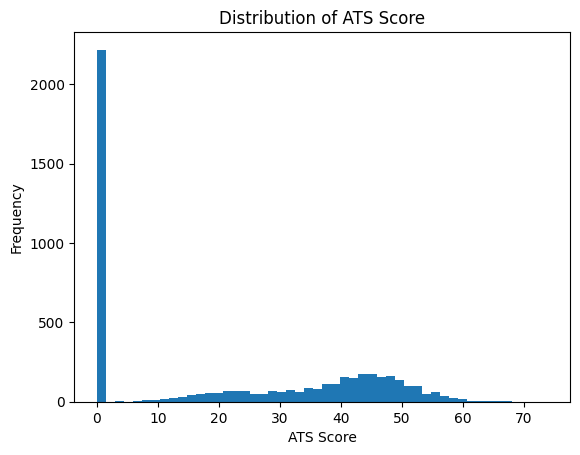

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("job_applicant_dataset_updated.csv")
# Plot ATS score distribution
plt.hist(df['ats_score'], bins=50)
plt.xlabel('ATS Score')
plt.ylabel('Frequency')
plt.title('Distribution of ATS Score')
plt.show()

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import numpy as np
from faker import Faker
import random

# Initialize Faker for generating realistic text
fake = Faker()

# Lists for generating realistic data
job_roles = ['Software Engineer', 'Data Scientist', 'Product Manager', 'DevOps Engineer', 'UX Designer']
skills_pool = ['Python', 'Java', 'C++', 'SQL', 'R', 'TensorFlow', 'AWS', 'Docker', 'Kubernetes', 'React',
               'Node.js', 'JavaScript', 'HTML', 'CSS', 'Agile', 'Scrum', 'UI/UX', 'Figma', 'Tableau', 'Power BI']
education_levels = ['Bachelor', 'Master', 'PhD', 'Diploma', 'None']
experience_levels = ['0-2 years', '3-5 years', '6-10 years', '10+ years']

def generate_resume_text():
    """Generate realistic resume text."""
    return (f"Name: {fake.name()}\n"
            f"Education: {random.choice(education_levels)} in {fake.job()}\n"
            f"Experience: {random.choice(experience_levels)} as {random.choice(job_roles)}\n"
            f"Skills: {', '.join(random.sample(skills_pool, random.randint(3, 8)))}\n"
            f"Summary: {fake.text(max_nb_chars=200)}")

def generate_job_description(job_role):
    """Generate realistic job description."""
    required_skills = random.sample(skills_pool, random.randint(4, 10))
    experience = random.choice(experience_levels)
    education = random.choice(education_levels) if random.random() > 0.3 else 'None'
    return (f"Job Title: {job_role}\n"
            f"Description: {fake.text(max_nb_chars=300)}\n"
            f"Required Skills: {', '.join(required_skills)}\n"
            f"Experience: {experience}\n"
            f"Education: {education}")

# Load the original dataset
df = pd.read_csv('job_applicant_dataset.csv')

# Create a subset of the dataset without resume_text and job_description
df_subset = df.drop(columns=['resume_text', 'job_description'])

# Create metadata for the subset dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_subset)

# Define constraints for numerical and categorical columns
metadata.update_column(column_name='education_match', sdtype='categorical')
metadata.update_column(column_name='skills_match', sdtype='numerical')
metadata.update_column(column_name='experience_match', sdtype='numerical')
metadata.update_column(column_name='text_similarity', sdtype='numerical')
metadata.update_column(column_name='ats_score', sdtype='numerical')

# Initialize the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Fit the synthesizer to the subset dataset
synthesizer.fit(df_subset)

# Generate 10000 synthetic rows
synthetic_data = synthesizer.sample(num_rows=10000)

# Ensure numerical columns are rounded and clipped appropriately
synthetic_data['skills_match'] = synthetic_data['skills_match'].clip(0, 100).round(2)
synthetic_data['experience_match'] = synthetic_data['experience_match'].clip(0, 1).round(2)
synthetic_data['text_similarity'] = synthetic_data['text_similarity'].clip(0, 100).round(2)
synthetic_data['ats_score'] = synthetic_data['ats_score'].clip(0, 100).round(2)
synthetic_data['education_match'] = synthetic_data['education_match'].clip(0, 1).astype(int)

# Add realistic resume_text and job_description to synthetic data
synthetic_data['resume_text'] = [generate_resume_text() for _ in range(10000)]
synthetic_data['job_description'] = [generate_job_description(job_role) for job_role in synthetic_data['job_role']]

# Reorder columns to match original dataset
synthetic_data = synthetic_data[['resume_text', 'job_description', 'job_role', 'job_skills',
                                 'education_match', 'skills_match', 'experience_match',
                                 'text_similarity', 'ats_score']]

# Save the synthetic dataset to CSV
synthetic_data.to_csv('synthetic_job_applicant_dataset.csv', index=False)
print("Synthetic dataset with 10000 rows generated and saved as 'synthetic_job_applicant_dataset.csv'.")

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:144: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:122: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Synthetic dataset with 10000 rows generated and saved as 'synthetic_job_applicant_dataset.csv'.


In [ ]:
# random forest regressor


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import re
from datetime import datetime

# Load the synthetic dataset
df = pd.read_csv('synthetic_job_applicant_dataset.csv')

# Initialize sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Helper functions for feature engineering
def calculate_skills_match(candidate_skills, job_skills):
    """Calculate percentage of skills matched."""
    candidate_skill_list = [skill['skill'].lower() for skill in candidate_skills]
    job_skill_list = [skill.strip().lower() for skill in job_skills.split(',')]
    matched_skills = len(set(candidate_skill_list).intersection(set(job_skill_list)))
    total_job_skills = len(job_skill_list)
    return (matched_skills / total_job_skills) * 100 if total_job_skills > 0 else 0.0

def calculate_experience_match(employment_history, job_role):
    """Calculate experience match score based on relevant job titles."""
    if not employment_history:
        return 0.0
    relevant_experience = 0
    for job in employment_history:
        if job_role.lower() in job['jobTitle'].lower() or job_role.lower() in job['description'].lower():
            # Estimate years of experience
            start_date = job['startDate']
            end_date = job['endDate'] if job['endDate'] else 'Present'
            if start_date and end_date:
                try:
                    start = datetime.strptime(start_date, '%m/%Y')
                    end = datetime.now() if end_date == 'Present' else datetime.strptime(end_date, '%m/%Y')
                    years = (end - start).days / 365.25
                    relevant_experience += years
                except:
                    continue
    # Map experience to score (e.g., 3+ years -> high score)
    if relevant_experience >= 6:
        return 1.0
    elif relevant_experience >= 3:
        return 0.75
    elif relevant_experience > 0:
        return 0.5
    return 0.0

def calculate_education_match(candidate_education, job_description):
    """Determine if education matches (1 if matched or not specified, 0 otherwise)."""
    job_edu = re.search(r'Education: (.*?)(?:\n|$)', job_description)
    job_edu = job_edu.group(1).strip() if job_edu else 'None'
    if job_edu == 'None':
        return 1
    candidate_degrees = [edu['degree'].lower() for edu in candidate_education]
    required_edu = job_edu.lower()
    return 1 if any(required_edu in degree for degree in candidate_degrees) else 0

def calculate_text_similarity(resume_text, job_description):
    """Calculate cosine similarity between resume and job description."""
    resume_summary = re.search(r'Summary\n(.*?)(?:\nEducation|\nSkills|\nExperience|$)', resume_text, re.DOTALL)
    resume_summary = resume_summary.group(1).strip() if resume_summary else resume_text
    job_desc = re.search(r'Description: (.*?)(?:\nRequired Skills|\nExperience|\nEducation|$)', job_description, re.DOTALL)
    job_desc = job_desc.group(1).strip() if job_desc else job_description

    embeddings = model.encode([resume_summary, job_desc])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity * 100

# Prepare features and target
X = []
y = df['ats_score'].values

for _, row in df.iterrows():
    # Simulate candidate data from resume_text
    candidate_skills = [{'skill': skill.strip()} for skill in row['job_skills'].split(',')]
    candidate_employment_history = [{'jobTitle': 'Sample Job', 'description': row['resume_text'], 'startDate': '01/2020', 'endDate': 'Present'}]
    candidate_education = [{'degree': re.search(r'Education: (.*?)\n', row['resume_text']).group(1)}]

    skills_match = calculate_skills_match(candidate_skills, row['job_skills'])
    experience_match = calculate_experience_match(candidate_employment_history, row['job_role'])
    education_match = calculate_education_match(candidate_education, row['job_description'])
    text_similarity = calculate_text_similarity(row['resume_text'], row['job_description'])

    X.append([skills_match, experience_match, education_match, text_similarity])

X = np.array(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

# Save the model and sentence transformer
with open('ats_score_model.pkl', 'wb') as f:
    pickle.dump({'rf_model': rf_model, 'sentence_model': model}, f)

print("Model saved as 'ats_score_model.pkl'.")

KeyboardInterrupt: 

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation MSE: 115.86430274080404
Test MSE: 113.73
Test R2: 0.11
Baseline MSE: 128.61
skills_match: 0.0000
experience_match: 0.1063
education_match: 0.1109
text_similarity: 0.7828


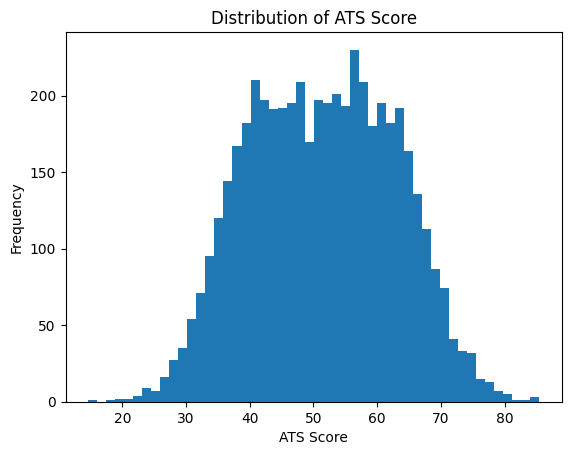

Model saved as 'ats_score_model.pkl'.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import re
from datetime import datetime
import matplotlib.pyplot as plt

# Load the synthetic dataset
df = pd.read_csv('job_applicant_dataset_updated.csv')

# Initialize sentence transformer model
model = SentenceTransformer('all-mpnet-base-v2')  # Upgraded model for better text_similarity

# Helper functions for feature engineering
def calculate_skills_match(candidate_skills, job_skills):
    """Calculate percentage of skills matched."""
    candidate_skill_list = [skill['skill'].lower() for skill in candidate_skills]
    job_skill_list = [skill.strip().lower() for skill in job_skills.split(',')]
    matched_skills = len(set(candidate_skill_list).intersection(set(job_skill_list)))
    total_job_skills = len(job_skill_list)
    return (matched_skills / total_job_skills) * 100 if total_job_skills > 0 else 0.0

def calculate_experience_match(employment_history, job_role):
    """Calculate experience match score based on relevant job titles."""
    if not employment_history:
        return 0.0
    relevant_experience = 0
    for job in employment_history:
        if job_role.lower() in job['jobTitle'].lower() or job_role.lower() in job['description'].lower():
            start_date = job['startDate']
            end_date = job['endDate'] if job['endDate'] else 'Present'
            if start_date and end_date:
                try:
                    start = datetime.strptime(start_date, '%m/%Y')
                    end = datetime.now() if end_date == 'Present' else datetime.strptime(end_date, '%m/%Y')
                    years = (end - start).days / 365.25
                    relevant_experience += years
                except:
                    continue
    if relevant_experience >= 6:
        return 1.0
    elif relevant_experience >= 3:
        return 0.75
    elif relevant_experience > 0:
        return 0.5
    return 0.0

def calculate_education_match(candidate_education, job_description):
    """Determine if education matches (1 if matched or not specified, 0 otherwise)."""
    job_edu = re.search(r'Education: (.*?)(?:\n|$)', job_description)
    job_edu = job_edu.group(1).strip() if job_edu else 'None'
    if job_edu == 'None':
        return 1
    candidate_degrees = [edu['degree'].lower() for edu in candidate_education]
    required_edu = job_edu.lower()
    return 1 if any(required_edu in degree for degree in candidate_degrees) else 0

def calculate_text_similarity(resume_text, job_description):
    """Calculate cosine similarity between resume and job description."""
    resume_summary = re.search(r'Summary\n(.*?)(?:\nEducation|\nSkills|\nExperience|$)', resume_text, re.DOTALL)
    resume_summary = resume_summary.group(1).strip() if resume_summary else resume_text
    job_desc = re.search(r'Description: (.*?)(?:\nRequired Skills|\nExperience|\nEducation|$)', job_description, re.DOTALL)
    job_desc = job_desc.group(1).strip() if job_desc else job_description

    embeddings = model.encode([resume_summary, job_desc])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity * 100

# Prepare features and target
X = []
y = df['ats_score'].values

for _, row in df.iterrows():
    # Simulate candidate data from resume_text
    candidate_skills = [{'skill': skill.strip()} for skill in row['job_skills'].split(',')]
    candidate_employment_history = [{'jobTitle': 'Sample Job', 'description': row['resume_text'], 'startDate': '01/2020', 'endDate': 'Present'}]
    candidate_education = [{'degree': re.search(r'Education: (.*?)\n', row['resume_text']).group(1)}]

    skills_match = calculate_skills_match(candidate_skills, row['job_skills'])
    experience_match = calculate_experience_match(candidate_employment_history, row['job_role'])
    education_match = calculate_education_match(candidate_education, row['job_description'])
    text_similarity = calculate_text_similarity(row['resume_text'], row['job_description'])

    X.append([skills_match, experience_match, education_match, text_similarity])

X = np.array(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and tune XGBoost model
xgb_model = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation MSE:", -grid_search.best_score_)

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")
print(f"Test R2: {r2:.2f}")

# Baseline MSE (predicting mean)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline MSE: {baseline_mse:.2f}")

# Feature importance
feature_names = ['skills_match', 'experience_match', 'education_match', 'text_similarity']
importances = xgb_model.feature_importances_
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

# Plot ATS score distribution
plt.hist(df['ats_score'], bins=50)
plt.xlabel('ATS Score')
plt.ylabel('Frequency')
plt.title('Distribution of ATS Score')
plt.show()

# Save the model and sentence transformer
with open('ats_score_model.pkl', 'wb') as f:
    pickle.dump({'xgb_model': xgb_model, 'sentence_model': model}, f)
print("Model saved as 'ats_score_model.pkl'.")